# Real vs fake news prediction model

## Import packages

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, tree
from sklearn.linear_model import SGDClassifier

## Read in datasets

In [2]:
real_df = pd.read_csv('~/documents/Data/Fake vs Real News/real_eng.csv', index_col = 0)
fake_df = pd.read_csv('~/documents/Data/Fake vs Real News/fake_eng.csv', index_col = 0)

## Transform data to correct format for sklearn modelling

#### Add a column to specify whether an article is real or fake

In [3]:
real_df['real_or_fake'] = 'real'
fake_df['real_or_fake'] = 'fake'

#### Concatenate the two articles into a single dataframe

In [4]:
news_df = pd.concat([real_df, fake_df])

#### Shuffle the rows of the dataframe

In [5]:
news_df = news_df.sample(frac=1)

In [6]:
news_df.sample(frac=1).head()

,title,text,length_title,proportion_capitals_title,real_or_fake
14895,Nepal scraps $2.5 billion hydropower plant dea...,KATHMANDU (Reuters) - Nepal has scrapped a $2....,68,0.029412,real
4201,Trump Supporter Threatens Montel Williams So ...,Montel Williams is an outspoken opponent of Do...,86,0.139535,fake
15861,Manila to focus on terrorism at Southeast Asia...,MANILA (Reuters) - Two weeks ahead of a region...,80,0.037500,real
512,Trump Told More Than A Thousand Documented Li...,What would you do if someone kept track of eve...,79,0.240506,fake
12291,LEFTISTS CALL FOR Ivanka Trump Brand Boycott…T...,Unhinged leftists are calling for a boycott of...,84,0.309524,fake


#### Feature and target columns

In [8]:
X = news_df[['length_title', 'proportion_capitals_title']]
y = news_df['real_or_fake']

#### Standardise the feature columns

In [9]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

#### Split the data into a training set and a testing set

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

## K-Nearest Neighbours Classifier

#### Set up the hyperparameter space for tuning

In [19]:
k_space = np.arange(2, 20, 2)

#### Initialise the cross-validation scores array

In [20]:
cv_scores = []

#### Fit the model to the dataset

In [55]:
tic = time.perf_counter()
for k in k_space:
    knn = KNeighborsClassifier(n_neighbors = k)
    cv_score = np.mean(cross_val_score(knn, X_train, y_train, cv = 5))
    cv_scores.append(cv_score)
toc = time.perf_counter()
print(round(toc - tic, 0), 'seconds')

10.06840699099996


#### Model accuracy

    k  Cross-validation scores
0   2                 0.980422
1   4                 0.983775
2   6                 0.984230
3   8                 0.984940
4  10                 0.984969
5  12                 0.985395
6  14                 0.985139
7  16                 0.985224
8  18                 0.985508


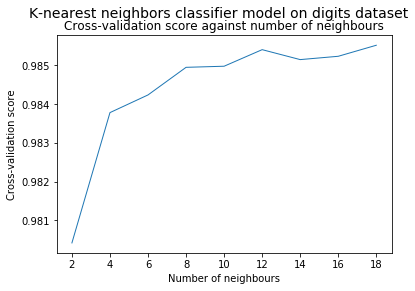

In [22]:
print(pd.DataFrame({'k': k_space,
                   'Cross-validation scores': cv_scores}))

plt.plot(k_space, cv_scores, linewidth = 1)
plt.suptitle('K-nearest neighbors classifier model on digits dataset', size = 14)
plt.title('Cross-validation score against number of neighbours')
plt.xlabel('Number of neighbours')
plt.ylabel('Cross-validation score')
plt.xticks(k_space)
plt.show()

#### Confusion matrix

In [67]:
knn = KNeighborsClassifier(n_neighbors = 12)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[1763    9]
 [  36 2103]]


## Support vector machine classifier

#### Set up the hyperparameter space for tuning

In [36]:
C_space = np.arange(0.2, 3, 0.2)

#### Initialise the cross-validation scores array

In [38]:
cv_scores = []

#### Fit the model to the dataset

In [40]:
tic = time.perf_counter()
for C in C_space:
    svc = svm.LinearSVC(C = C, max_iter = 2000)
    cv_score = np.mean(cross_val_score(svc, X_train, y_train, cv = 5))
    cv_scores.append(cv_score)
toc = time.perf_counter()
print(round(toc - tic, 0), 'seconds')

#### Model accuracy

      C  Cross-validation scores
0   0.2                 0.985082
1   0.4                 0.985167
2   0.6                 0.985224
3   0.8                 0.985224
4   1.0                 0.985224
5   1.2                 0.985224
6   1.4                 0.985224
7   1.6                 0.985224
8   1.8                 0.985224
9   2.0                 0.985224
10  2.2                 0.985224
11  2.4                 0.985224
12  2.6                 0.985224
13  2.8                 0.985224


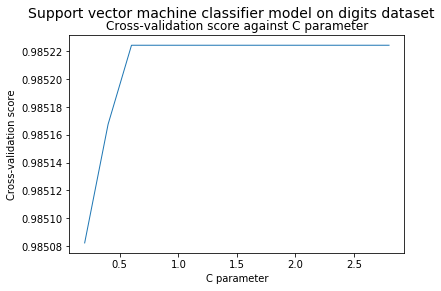

In [42]:
print(pd.DataFrame({'C': C_space,
                   'Cross-validation scores': cv_scores}))

plt.plot(C_space, cv_scores, linewidth = 1)
plt.suptitle('Support vector machine classifier model on digits dataset', size = 14)
plt.title('Cross-validation score against C parameter')
plt.xlabel('C parameter')
plt.ylabel('Cross-validation score')
plt.show()

#### Confusion matrix

In [68]:
svc = svm.LinearSVC(C = 0.6, max_iter = 2000)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[1760   12]
 [  24 2115]]


# Stochastic gradient descent classifier

#### Set up the hyperparameter space for tuning

In [49]:
alpha_space = np.arange(5e-6, 2e-5, 1e-6)

#### Initialise the cross-validation scores array

In [50]:
cv_scores = []

#### Fit the model to the dataset

In [51]:
tic = time.perf_counter()
for a in alpha_space:
    sgdc = SGDClassifier(alpha = a)
    cv_score = np.mean(cross_val_score(sgdc, X_train, y_train, cv = 5))
    cv_scores.append(cv_score)
toc = time.perf_counter()
print(round(toc - tic, 0), 'seconds')

#### Model accuracy

       alpha  Cross-validation scores
0   0.000005                 0.982951
1   0.000006                 0.984372
2   0.000007                 0.984258
3   0.000008                 0.983491
4   0.000009                 0.984287
5   0.000010                 0.984599
6   0.000011                 0.985196
7   0.000012                 0.984315
8   0.000013                 0.984400
9   0.000014                 0.984002
10  0.000015                 0.984429
11  0.000016                 0.983917
12  0.000017                 0.984628
13  0.000018                 0.984770
14  0.000019                 0.984173
15  0.000020                 0.984486


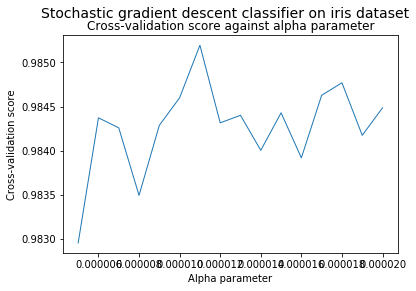

In [52]:
print(pd.DataFrame({'alpha': alpha_space,
                   'Cross-validation scores': cv_scores}))

plt.plot(alpha_space, cv_scores, linewidth = 1)
plt.suptitle('Stochastic gradient descent classifier on iris dataset', size = 14)
plt.title('Cross-validation score against alpha parameter')
plt.xlabel('Alpha parameter')
plt.ylabel('Cross-validation score')
plt.show()

#### Confusion matrix

In [69]:
sgdc = SGDClassifier(alpha = 1.1e-5)
sgdc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[1760   12]
 [  24 2115]]


## Decision tree classifier

#### Set up the parameter space

In [57]:
max_depth_space = np.arange(1, 12, 1)

#### Initialise the cross-validation scores array

In [58]:
cv_scores = []

#### Fit the model to the dataset

In [60]:
tic = time.perf_counter()
for d in max_depth_space:
    dec_tree = tree.DecisionTreeClassifier(max_depth = d)
    cv_score = np.mean(cross_val_score(dec_tree, X_train, y_train, cv = 5))
    cv_scores.append(cv_score)
toc = time.perf_counter()
print(round(toc - tic, 0), 'seconds')

3.0 seconds


#### Model accuracy

    max_depth  Cross-validation scores
0           1                 0.982241
1           2                 0.982241
2           3                 0.984372
3           4                 0.984997
4           5                 0.984599
5           6                 0.984201
6           7                 0.984798
7           8                 0.984770
8           9                 0.984429
9          10                 0.984315
10         11                 0.984230


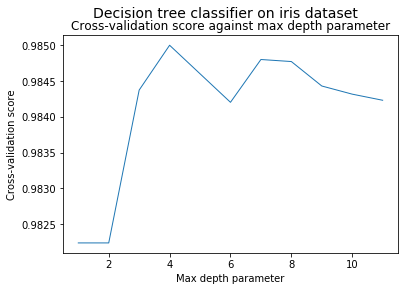

In [61]:
print(pd.DataFrame({'max_depth': max_depth_space,
                   'Cross-validation scores': cv_scores}))

plt.plot(max_depth_space, cv_scores, linewidth = 1)
plt.suptitle('Decision tree classifier on iris dataset', size = 14)
plt.title('Cross-validation score against max depth parameter')
plt.xlabel('Max depth parameter')
plt.ylabel('Cross-validation score')
plt.show()

#### Confusion matrix

In [71]:
dec_tree = tree.DecisionTreeClassifier(max_depth = 4)
sgdc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[1760   12]
 [  24 2115]]
